In [1]:
# import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = yf.download(tickers=['cvx'],start = '2020-01-01',end='2023-05-01', period='1')
y = df['Close'].fillna(method='ffill')
df
# generate the input and output sequences





[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,120.809998,121.629997,120.769997,121.430000,104.474884,5205000
2020-01-03,121.779999,122.720001,120.739998,121.010002,104.113533,6360900
2020-01-06,121.239998,121.669998,120.330002,120.599998,103.760780,9953000
2020-01-07,119.019997,119.730003,117.769997,119.059998,102.435822,7856900
2020-01-08,118.550003,119.089996,117.650002,117.699997,101.265701,7295900
...,...,...,...,...,...,...
2023-04-24,169.100006,172.380005,168.580002,171.479996,171.479996,7177600
2023-04-25,170.320007,170.399994,168.429993,168.990005,168.990005,5807200
2023-04-26,168.210007,168.949997,165.229996,165.979996,165.979996,5927400


In [2]:
# reshaping close column or variable y from main data set 
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)


In [3]:
# generate the input and output sequences
n_lookback = 50  # length of input sequences (lookback period)
n_forecast = 4  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [4]:
# fit the model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=100))
model.add(Dense(n_forecast))



In [5]:
# declare epoch and batch size to train 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=16, verbose=0)


In [6]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)


1/1 [==============================] - 1s 626ms/step


C:\Users\Abhud\AppData\Local\Temp\ipykernel_16656\1092218291.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<AxesSubplot:title={'center':'CVX'}, xlabel='Date'>

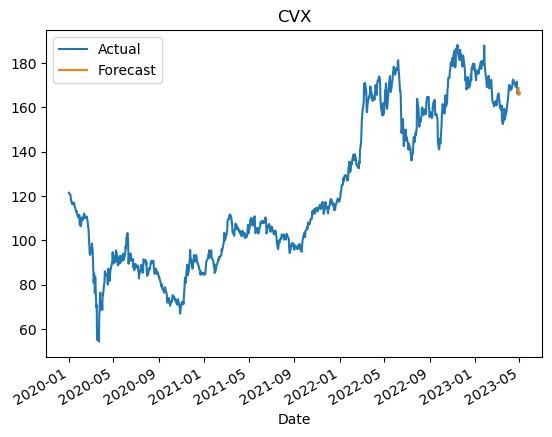

In [8]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='CVX')

In [9]:
# Forecast 
df_future

,Date,Actual,Forecast
0,2023-04-29,NaN,165.503342
1,2023-04-30,NaN,165.599243
2,2023-05-01,NaN,166.721603
3,2023-05-02,NaN,166.146118


<AxesSubplot:xlabel='Date'>

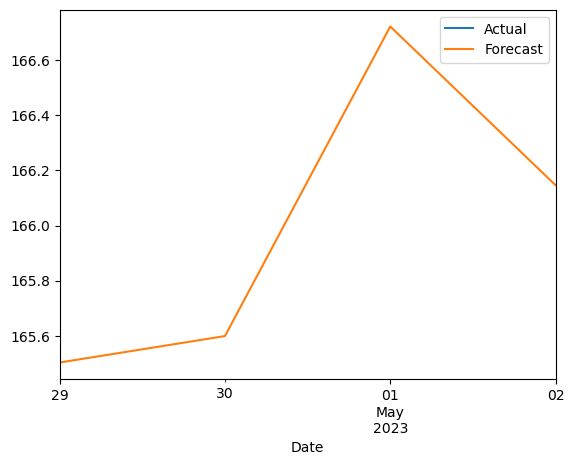

In [10]:
# Forecast plot against date
br = df_future.set_index('Date')
br.plot()